# 06 Model Comparison

多模型性能对比，包括 MAE、RMSE、F1 等指标。

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import os

from utils.data_loader import load_predictions, load_training_results
from utils.visualizer import plot_metrics_scatter, plot_error_histogram, plot_calibration_curve
from utils.config import CHECKPOINT_DIR

## 加载所有模型预测结果

In [2]:
# ????????
pred_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.startswith('predictions_') and f.endswith('.npz')]
pred_files.sort()

print("???????:")
for f in pred_files:
    print(f"  - {f}")

# ????????????????????
predictions = {}
for f in pred_files:
    npz_path = os.path.join(CHECKPOINT_DIR, f)
    file_tag = f.replace('predictions_', '').replace('.npz', '')

    with np.load(npz_path) as data:
        keys = set(data.files)

    loaded = False

    if 'gt_pred' in keys:
        y_true, y_pred = load_predictions(npz_path, model='gt')
        predictions[f'gt_{file_tag}'] = {'y_true': y_true, 'y_pred': y_pred}
        loaded = True

    if 'pinn_pred' in keys:
        y_true, y_pred = load_predictions(npz_path, model='pinn')
        predictions[f'pinn_{file_tag}'] = {'y_true': y_true, 'y_pred': y_pred}
        loaded = True

    if not loaded and 'y_true' in keys and 'y_pred' in keys:
        y_true, y_pred = load_predictions(npz_path)
        predictions[file_tag] = {'y_true': y_true, 'y_pred': y_pred}
        loaded = True

    if not loaded:
        print(f"?? {f}: ????? {sorted(keys)}")

print(f"\n??? {len(predictions)} ???????")
print("????:")
for name in predictions:
    print(f"  - {name}")


???????:
  - predictions_20260223_231426.npz
  - predictions_20260223_232135.npz
  - predictions_combined_latest_split_20260223_232547.npz

??? 4 ???????
????:
  - gt_20260223_231426
  - pinn_20260223_232135
  - gt_combined_latest_split_20260223_232547
  - pinn_combined_latest_split_20260223_232547


## 计算评估指标

In [3]:
def calculate_metrics(y_true, y_pred):
    """计算各种评估指标"""
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# 计算每个模型的指标
metrics = {}
for model_name, data in predictions.items():
    y_true = data['y_true']
    y_pred = data['y_pred']
    
    # 展平用于指标计算
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    metrics[model_name] = calculate_metrics(y_true_flat, y_pred_flat)

# 显示指标表格
print("\n" + "=" * 60)
print("模型性能对比")
print("=" * 60)
print(f"{'Model':<30} {'MAE':<10} {'RMSE':<10} {'R2':<10}")
print("-" * 60)
for model_name, m in metrics.items():
    print(f"{model_name:<30} {m['MAE']:<10.6f} {m['RMSE']:<10.6f} {m['R2']:<10.6f}")


模型性能对比
Model                          MAE        RMSE       R2        
------------------------------------------------------------
gt_20260223_231426             0.086920   0.123878   0.027719  
pinn_20260223_232135           0.470837   0.484840   -13.893494
gt_combined_latest_split_20260223_232547 0.086920   0.123878   0.027719  
pinn_combined_latest_split_20260223_232547 0.470837   0.484840   -13.893494


## 绘制预测 vs 真实散点图

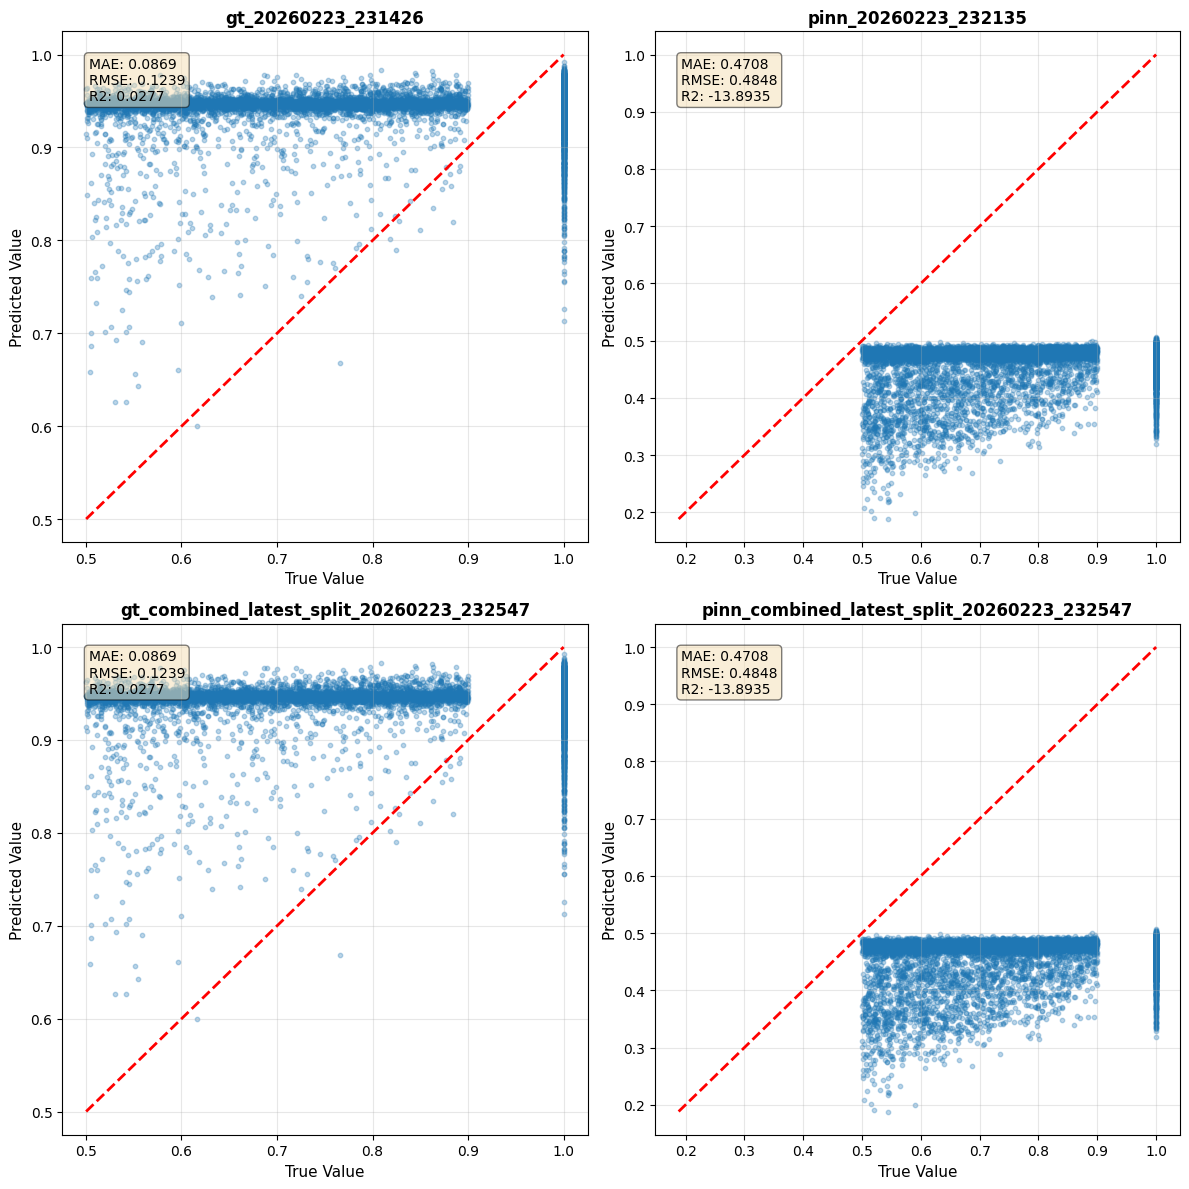

In [4]:
# 选择前几个模型展示
n_models = min(4, len(predictions))
model_names = list(predictions.keys())[:n_models]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    y_true = predictions[model_name]['y_true'].flatten()
    y_pred = predictions[model_name]['y_pred'].flatten()
    
    axes[idx].scatter(y_true, y_pred, alpha=0.3, s=10)
    
    # 完美预测线
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    m = metrics[model_name]
    axes[idx].text(0.05, 0.95, f"MAE: {m['MAE']:.4f}\nRMSE: {m['RMSE']:.4f}\nR2: {m['R2']:.4f}",
                  transform=axes[idx].transAxes, fontsize=10, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    axes[idx].set_xlabel('True Value', fontsize=11)
    axes[idx].set_ylabel('Predicted Value', fontsize=11)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 误差分布对比

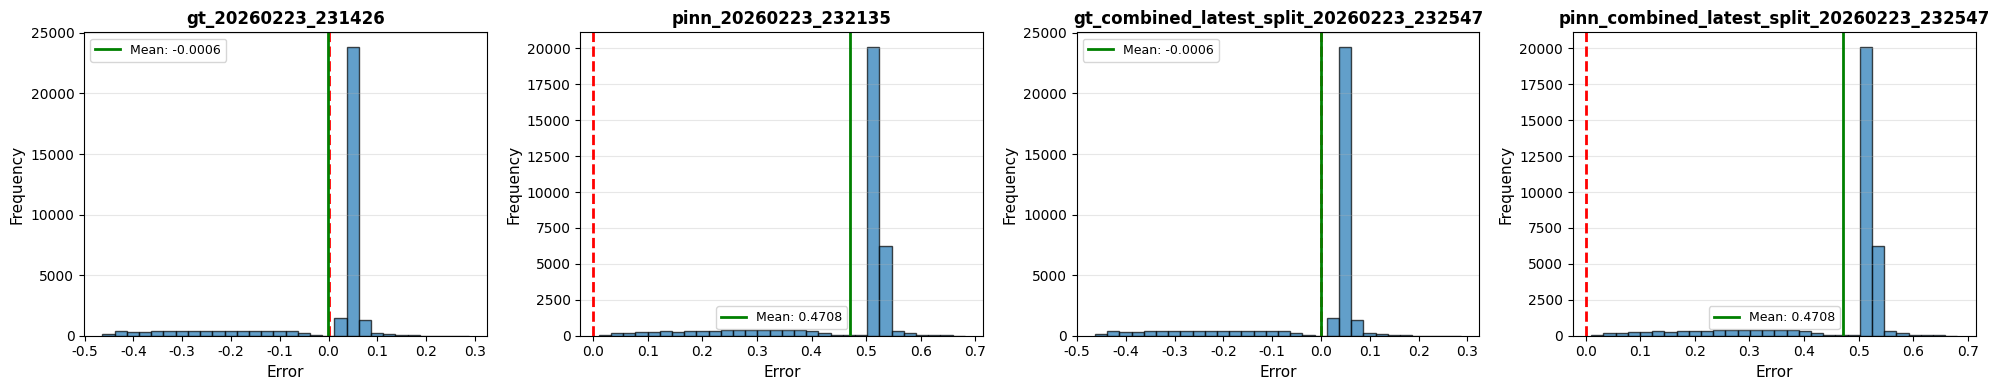

In [5]:
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
if n_models == 1:
    axes = [axes]

for idx, model_name in enumerate(model_names):
    y_true = predictions[model_name]['y_true'].flatten()
    y_pred = predictions[model_name]['y_pred'].flatten()
    errors = y_true - y_pred
    
    axes[idx].hist(errors, bins=30, edgecolor='black', alpha=0.7)
    axes[idx].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[idx].axvline(x=np.mean(errors), color='g', linestyle='-', linewidth=2, label=f'Mean: {np.mean(errors):.4f}')
    
    axes[idx].set_xlabel('Error', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 模型性能柱状图对比

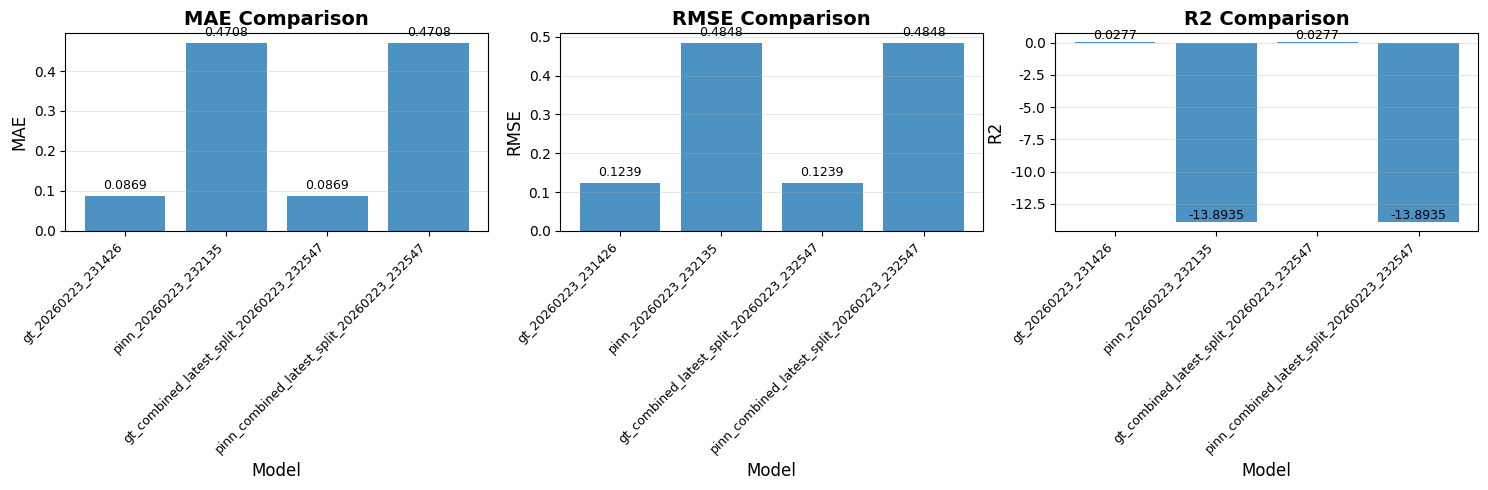

In [6]:
# 绘制指标对比柱状图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metric_names = ['MAE', 'RMSE', 'R2']

for idx, metric_name in enumerate(metric_names):
    values = [metrics[m][metric_name] for m in model_names]
    bars = axes[idx].bar(range(len(model_names)), values, alpha=0.8)
    
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric_name, fontsize=12)
    axes[idx].set_title(f'{metric_name} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(range(len(model_names)))
    axes[idx].set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # 添加数值标签
    for bar, val in zip(bars, values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()